#Setting up colab gpu runtime environment

In [58]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-vpsipxzc
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-vpsipxzc
  Resolved https://github.com/albumentations-team/albumentations to commit 7eda70e01e7f3bb31c1085e4fa473089b5a468be
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Downloading Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [59]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


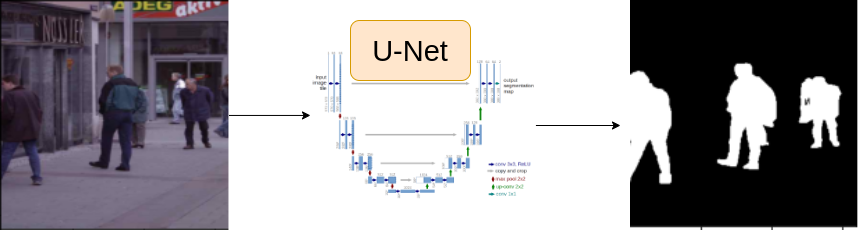

# Some Common Imports

In [60]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [61]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setting Up Configurations

In [120]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE='cuda'

EPOCHS=25
LR=3*1e-3
IMAGE_SIZE=320
BATCH_SIZE=16

ENCODER='efficientnet-b0'
WEIGHTS='imagenet'

In [63]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [64]:
row=df.iloc[4]

image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

In [82]:
print(image.shape)
mask.shape

(408, 612, 3)


(408, 612)

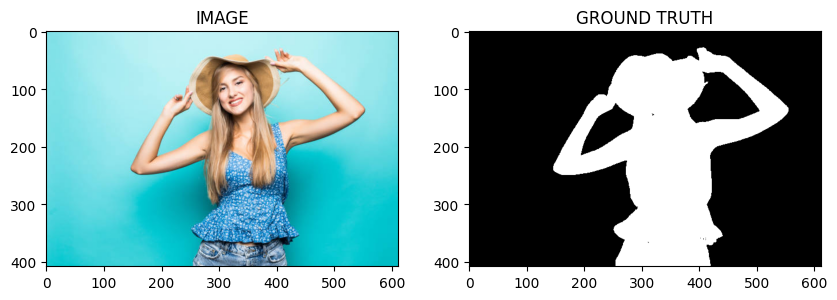

In [65]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [46]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [67]:
import albumentations as A

In [68]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

# Creating Custom Dataset

In [69]:
from torch.utils.data import Dataset

In [99]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]

    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask=np.expand_dims(mask,axis=-1) #(h,w,c)



    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

    #convert from (h,w,c) to (c,h,w) as pytorch requires

    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask

In [100]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [101]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


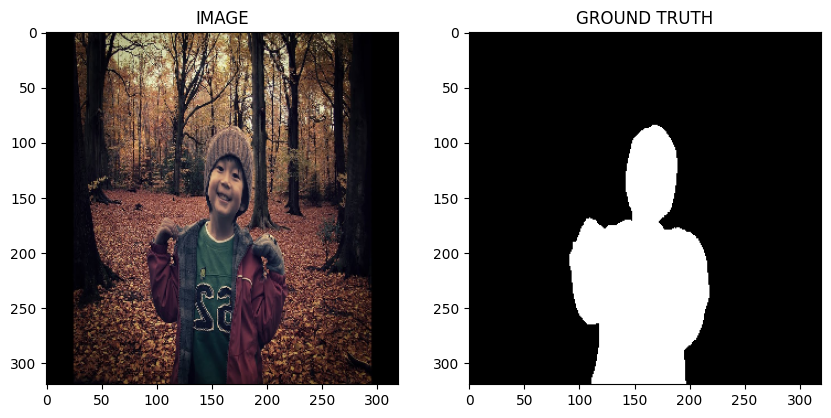

In [102]:
#visualize

idx=21
image,mask=trainset[idx]
helper.show_image(image,mask)

# Loading dataset into batches

In [107]:
from torch.utils.data import DataLoader

In [108]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [111]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [112]:
for images,masks in trainloader:
  break
print(images.shape,masks.shape)

torch.Size([16, 3, 320, 320]) torch.Size([16, 1, 320, 320])


# Creating Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [115]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [157]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )
  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks!=None:  #during training

      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2

    return logits #during inference


In [158]:
model=SegmentationModel()
model=model.to(DEVICE)

#Train and Validation Functions

In [159]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0

  for images,masks in tqdm(data_loader):
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
  return total_loss/len(data_loader)

In [160]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)

      logits,loss=model(images,masks)
      total_loss+=loss.item()

  return total_loss/len(data_loader)

# Train Model

In [161]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [162]:
best_valid_loss=np.inf
for epoch in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss<best_valid_loss:
    best_valid_loss=valid_loss
    torch.save(model.state_dict(),'best_model.pth')

  print(f"Epoch : {epoch+1} train_loss : {train_loss:.4f} valid_loss : {valid_loss:.4f}")

100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch : 1 train_loss : 0.7289 valid_loss : 1.0331


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


Epoch : 2 train_loss : 0.3803 valid_loss : 1.0018


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch : 3 train_loss : 0.3034 valid_loss : 2.2951


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch : 4 train_loss : 0.2537 valid_loss : 1.3995


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch : 5 train_loss : 0.2532 valid_loss : 1.5905


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch : 6 train_loss : 0.2377 valid_loss : 0.8825


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


Epoch : 7 train_loss : 0.2235 valid_loss : 0.6627


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch : 8 train_loss : 0.2344 valid_loss : 0.6302


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch : 9 train_loss : 0.1828 valid_loss : 0.5378


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch : 10 train_loss : 0.1712 valid_loss : 0.3550


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch : 11 train_loss : 0.1638 valid_loss : 0.6205


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch : 12 train_loss : 0.2148 valid_loss : 0.3565


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch : 13 train_loss : 0.1568 valid_loss : 0.3585


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch : 14 train_loss : 0.1392 valid_loss : 0.3760


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch : 15 train_loss : 0.1867 valid_loss : 0.3771


100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch : 16 train_loss : 0.1745 valid_loss : 0.5049


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch : 17 train_loss : 0.1552 valid_loss : 0.3367


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch : 18 train_loss : 0.1508 valid_loss : 0.2965


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 19 train_loss : 0.1673 valid_loss : 0.3632


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch : 20 train_loss : 0.1401 valid_loss : 0.2716


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch : 21 train_loss : 0.1854 valid_loss : 0.3597


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Epoch : 22 train_loss : 0.1487 valid_loss : 0.3337


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch : 23 train_loss : 0.1304 valid_loss : 0.2925


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


Epoch : 24 train_loss : 0.1212 valid_loss : 0.1926


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch : 25 train_loss : 0.1101 valid_loss : 0.1881


#  Inference

In [180]:
idx=1

model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

image,mask=validset[idx]

logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

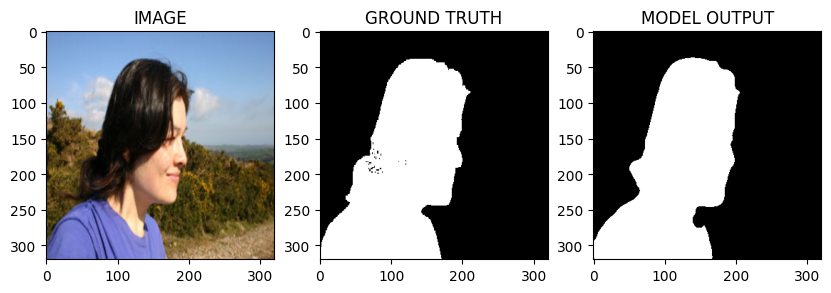

In [181]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))